
# Use case for "Modeling resilient cyber-physical processes and their composition from digital twins via Markov Decision Processes"

In this notebook, we present the implementation of the use cases for the paper "Modeling resilient cyber-physical processes and their composition from digital twins via Markov Decision Processes", submitted at BPM 2022.


Table of contents:

- [Preliminaries](#Preliminaries)
  - [Available services](#Available-services)
  - [Target specification](#Target-specification)
- [Economic cost > Quality cost](#Economic-cost->-Quality-cost)
  - [Discussion](#Economic-cost->-Quality-cost:-Discussion)
- [Quality-cost > Economic cost](#Quality-cost->-Economic-cost)
  - [Discussion](#Quality-cost->-Economic-cost:-Discussion)
- [Increasing broken probability](#Increasing-broken-probability)
  - [Discussion](#Increasing-broken-probability:-Discussion)
- [Using Tau Actions](#Using-Tau-Actions)
  - [Discussion](#Using-Tau-Actions:-Discussion)

## Preliminaries

### Available services

We start with the definitions of the available services and the DECLARE constraints of the task.


In [1]:
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service, print_policy_data, \
    print_value_function, print_q_value_function
from stochastic_service_composition.declare_utils import exactly_once, absence_2, alt_succession, alt_precedence, \
    build_declare_assumption, not_coexistence
from stochastic_service_composition.dfa_target import mdp_from_dfa
from stochastic_service_composition.momdp import compute_final_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from mdp_dp_rl.processes.det_policy import DetPolicy
from stochastic_service_composition.dfa_target import MdpDfa



In [2]:
# default economic cost value
DEFAULT_REWARD_ECONOMIC_COST = -1.0

# default quality cost value
DEFAULT_REWARD_QUALITY_COST = -1.0

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -2.0

# default reward to repair the device
DEFAULT_REWARD_REPAIR = -1.0

# default probability of being broken after an action
DEFAULT_BROKEN_PROB = 0.05

# default discount factor
GAMMA = 0.99

HIGH_COST = -2.0
LOW_COST = -0.5

In [3]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

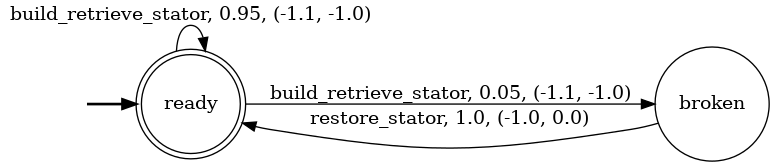

In [4]:
def stator_builder_service(
        economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST,
        quality_cost: float = DEFAULT_REWARD_QUALITY_COST,
        broken_prob: float = DEFAULT_BROKEN_PROB,
        broken_reward: float = DEFAULT_BROKEN_REWARD,
        repair_reward: float = DEFAULT_REWARD_REPAIR
) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob

    average_action_reward = economic_cost * (1 - broken_prob) + (economic_cost + broken_reward) * broken_prob

    transitions = {
        "ready": {
          BUILD_RETRIEVE_STATOR: ({"ready": success_prob, "broken": broken_prob}, (average_action_reward, quality_cost)),
        },
        "broken": {
            "restore_stator": ({"ready": 1.0}, (repair_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

service_stator_builder = stator_builder_service()
render_service(service_stator_builder)

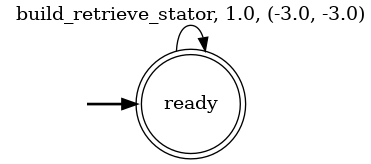

In [5]:
def stator_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_STATOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_stator_warehouse = stator_warehouse_service(economic_cost=-3.0, quality_cost=-3.0)
render_service(service_stator_warehouse)

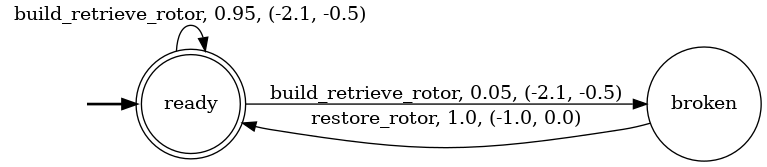

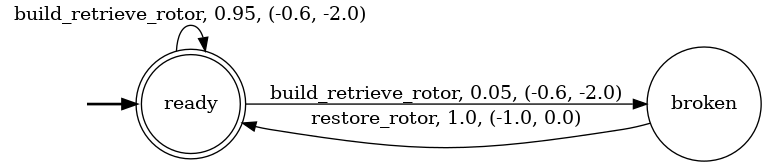

In [6]:
def rotor_builder_service(
        economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST,
        quality_cost: float = DEFAULT_REWARD_QUALITY_COST,
        broken_prob: float = DEFAULT_BROKEN_PROB,
        broken_reward: float = DEFAULT_BROKEN_REWARD,
        repair_reward: float = DEFAULT_REWARD_REPAIR
) -> Service:
    """Build the rotor builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob

    average_action_reward = economic_cost * (1 - broken_prob) + (economic_cost + broken_reward) * broken_prob

    transitions = {
        "ready": {
          BUILD_RETRIEVE_ROTOR: ({"ready": success_prob, "broken": broken_prob}, (average_action_reward, quality_cost)),
        },
        "broken": {
            "restore_rotor": ({"ready": 1.0}, (repair_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

# high economic cost - low quality cost
service_rotor_builder_1 = rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_rotor_builder_2 = rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

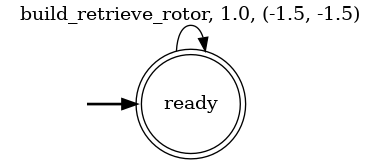

In [7]:
def rotor_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the rotor warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_ROTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_rotor_warehouse = rotor_warehouse_service(-1.5, -1.5)
render_service(service_rotor_warehouse)

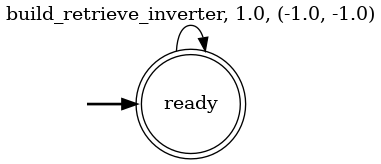

In [8]:
def inverter_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the inverter warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_INVERTER: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_inverter_warehouse = inverter_warehouse_service()
render_service(service_inverter_warehouse)

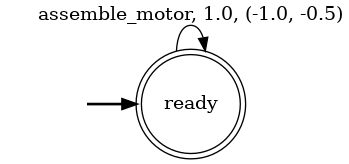

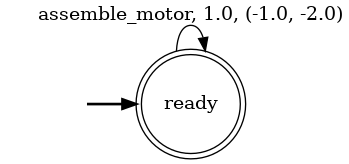

In [9]:
def assembler_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the assembler device."""
    transitions = {
        "ready": {
            ASSEMBLE_MOTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_assembler_1 = assembler_service(quality_cost=LOW_COST)
# low economic cost - high quality cost
service_assembler_2 = assembler_service(quality_cost=HIGH_COST)
render_service(service_assembler_1)
render_service(service_assembler_2)

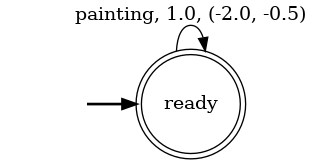

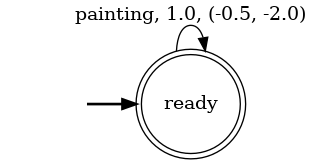

In [10]:
def painter_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the painter device."""
    transitions = {
        "ready": {
            PAINTING: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_painter_1 = painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_painter_2 = painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_painter_1)
render_service(service_painter_2)

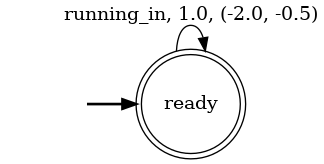

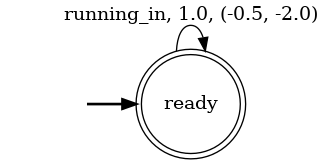

In [11]:
def smart_tester_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the smart tester device."""
    transitions = {
        "ready": {
            RUNNING_IN: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_smart_tester_1 = smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_smart_tester_2 = smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

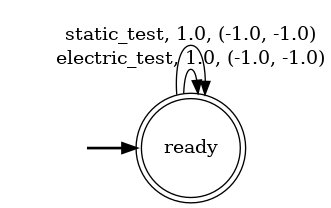

In [12]:
def mechanical_engineer_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the mechanical engineer device."""
    transitions = {
        "ready": {
            ELECTRIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
            STATIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_mechanical_engineer = mechanical_engineer_service()
render_service(service_mechanical_engineer)

### Target specification

In this section, we list all the DECLARE constraints, transform each of them in LTLf formulas (according to the paper) and put them in conjunction in order to compute the equivalent automaton.

Then, we also show the MDP representation of the DFA.

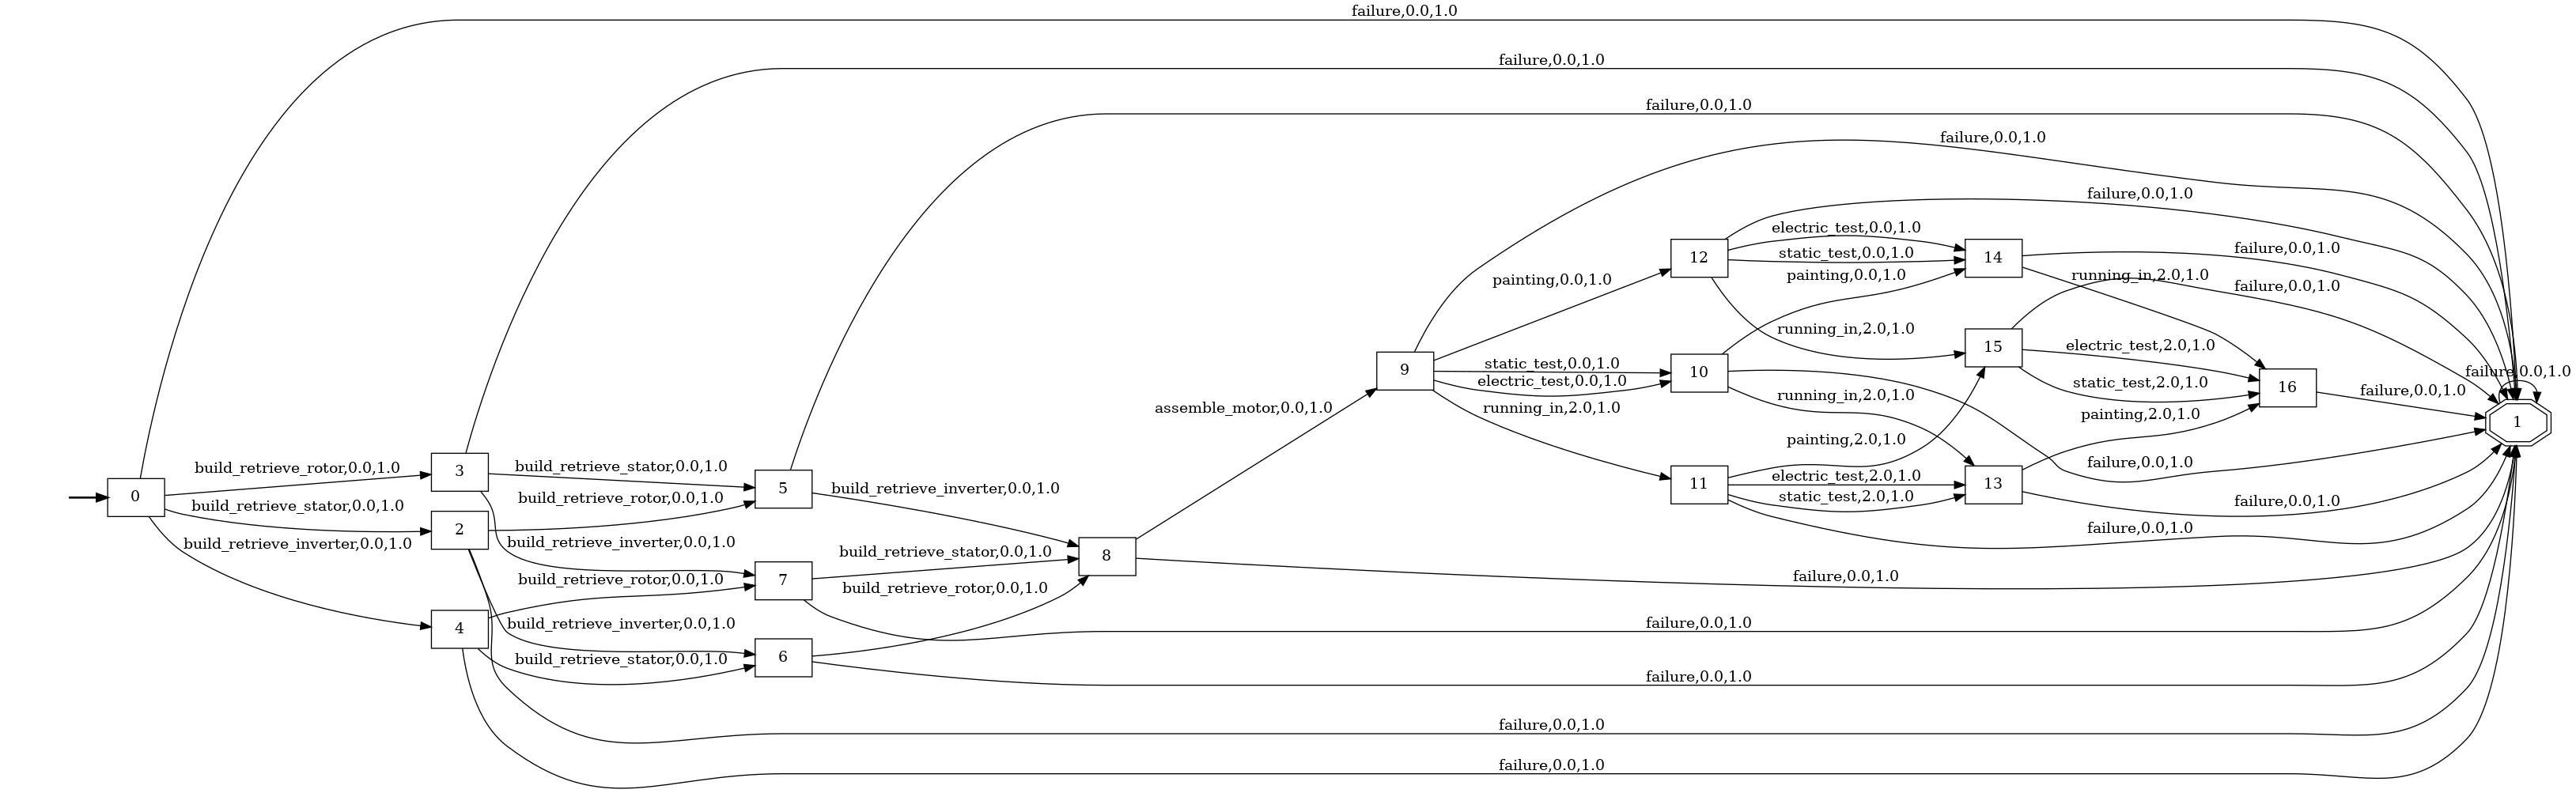

In [13]:

declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]
formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
target_mdp = mdp_from_dfa(automaton, gamma=GAMMA)
render_mdp_dfa(target_mdp)

Here we list all the services.

In [14]:
all_services = [
    stator_builder_service(),                                                    # 0
    stator_warehouse_service(economic_cost=-3.0, quality_cost=-3.0),             # 1
    rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),       # 2
    rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),       # 3
    rotor_warehouse_service(-1.5, -1.5),                                         # 4
    inverter_warehouse_service(),                                                # 5
    assembler_service(quality_cost=LOW_COST),                                    # 6
    assembler_service(quality_cost=HIGH_COST),                                   # 7
    painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),             # 8
    painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),             # 9
    smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),        # 10
    smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),        # 11
    mechanical_engineer_service(),                                               # 12
]


## Economic cost > Quality cost

In the following, we compute the composition MOMDP by giving more weight to the economic cost (`2.0`) rather than the quality cost (`1.0`). The highest weight is to the target specification (`10.0`). The optimal solution will prefer using services whose economic cost of performing the main action is lower.


In [15]:
def execute_n_action_of_policy(mdp: MdpDfa, policy: DetPolicy, n, initial_state=None):
    current_state = mdp.initial_state if initial_state is None else initial_state
    for _ in range(n):
        action = policy.get_action_for_state(current_state)
        next_state_dist = mdp.transitions[current_state][action]
        reward = mdp.rewards[current_state][action]
        next_state_highest_prob = max(next_state_dist.items(), key=lambda pair: pair[1])[0]
        print(f"action={action}, reward={reward}")
        current_state = next_state_highest_prob

In [16]:
weights = [10.0, 2.0, 1.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
print("Number of states: ", len(final_mdp.all_states))
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

Number of states:  80


In [17]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 6)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 11)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 11)
State=(('broken', 're

In [18]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-248.51494999999977
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-249.0049999999998
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-192.78936220534922
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-191.7064264700498
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-191.1176024949998
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-210.2198004999998
State=(('broken', 'ready', 'broken', '

In [19]:
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_stator', 0), reward=-3.2
action=('build_retrieve_rotor', 3), reward=-3.2
action=('assemble_motor', 6), reward=-2.5
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0


### Economic cost > Quality cost: Discussion

In the above cell you can see the computed optimal plan:

```
action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_stator', 0), reward=-3.2
action=('build_retrieve_rotor', 3), reward=-3.2
action=('assemble_motor', 6), reward=-2.5
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0
```

You can notice that the optimal plan preferred actions from services with lower economic cost. E.g. to perform `build_retrieve_rotor`, the plan preferred using `service_rotor_builder_2` (service `3`) rather than `service_rotor_builder_1` (service `2`).
The same holds for the `service_painter_2` (service `9`) and `service_smart_tester_2` (service `11`).
Note however that `service_assembler_1` (service `6`) is preferred over `service_assembler_2` (service `7`) because they have the same economic cost but `service_assembler_1` has a lower quality cost.

Moreover, note that the reward of satisfaction of the target specification is given as soon as `running_in` is performed; this is because by the specification `painting` and `electric_test` are optional, and since the reward is given for each prefix that satisfies the constraints then the optimizer realized it was better to execute the `running_in` action as soon as possible. To reward only complete traces, we refer to the "Getting rewards for complete traces only" section in:

Brafman, Ronen, Giuseppe De Giacomo, and Fabio Patrizi. "LTLf/LDLf non-markovian rewards." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 32. No. 1. 2018.


## Quality cost > Economic cost

In the following, we compute the composition MOMDP by giving more weight to the quality cost (`5.0`) rather than the economic cost (`1.0`). The highest weight is to the target specification (`10.0`). The optimal solution will prefer using services whose quality cost of performing the main action is lower.


In [20]:
weights = [10.0, 1.0, 5.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
print("Number of states: ", len(final_mdp.all_states))
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

Number of states:  80


In [21]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 6)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 10)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 10)
State=(('broken', 're

In [22]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-342.5747499999997
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-345.0249999999997
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-293.90081332674714
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-290.8089023502497
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-290.2110124749997
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-307.3140024999997
State=(('broken', 'ready', 'broken', 'r

In [23]:
print_q_value_function(q_value_function)

Q-value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1):
	Action=('assemble_motor', 6),	Value=-342.6490024999997
	Action=('assemble_motor', 7),	Value=-350.1490024999997
	Action=('build_retrieve_inverter', 5),	Value=-345.1490024999997
	Action=('build_retrieve_rotor', 4),	Value=-348.1490024999997
	Action=('build_retrieve_stator', 1),	Value=-357.1490024999997
	Action=('electric_test', 12),	Value=-345.1490024999997
	Action=('painting', 8),	Value=-343.6490024999997
	Action=('painting', 9),	Value=-349.6490024999997
	Action=('restore_rotor', 2),	Value=-342.57474999999977
	Action=('restore_rotor', 3),	Value=-342.5747499999997
	Action=('restore_stator', 0),	Value=-342.5747499999997
	Action=('running_in', 10),	Value=-343.6490024999997
	Action=('running_in', 11),	Value=-349.6490024999997
	Action=('static_test', 12),	Value=-345.1490024999997

State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready',

In [24]:
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_rotor', 2), reward=-4.6
action=('build_retrieve_inverter', 5), reward=-6.0
action=('build_retrieve_stator', 0), reward=-6.1
action=('assemble_motor', 6), reward=-3.5
action=('running_in', 10), reward=15.5
action=('painting', 8), reward=15.5
action=('electric_test', 12), reward=14.0


### Quality cost > Economic cost: Discussion

In the above cell you can see the computed optimal plan:

```
action=('build_retrieve_rotor', 2), reward=-4.6
action=('build_retrieve_inverter', 5), reward=-6.0
action=('build_retrieve_stator', 0), reward=-6.1
action=('assemble_motor', 6), reward=-3.5
action=('running_in', 10), reward=15.5
action=('painting', 8), reward=15.5
action=('electric_test', 12), reward=14.0
```

You can notice that the optimal plan preferred actions from services with lower quality cost. E.g. to perform `build_retrieve_rotor`, the plan preferred using `service_rotor_builder_1` (service `2`) rather than `service_rotor_builder_2` (service `3`).
The same holds for `service_painter_1` (service `8`) and `service_smart_tester_2` (service `10`).
Note however that, as before, `service_assembler_1` (service `6`) is preferred over `service_assembler_2` (service `7`) because they have the same economic cost but `service_assembler_1` has a lower quality cost.



## Increasing broken probability

In this section, we show how the model is able to choose the right action in the case some parameter of the model changes, e.g. the probability of being broken. For example, we now use rotor builders with probability of being broken after performing the action of 40% (rather than 5%).




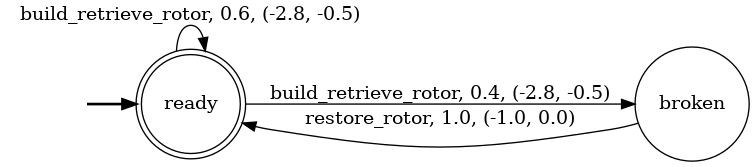

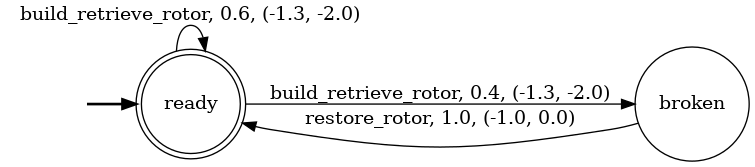

In [25]:
# high economic cost - low quality cost
service_rotor_builder_1 = rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST, broken_prob=0.4)
# low economic cost - high quality cost
service_rotor_builder_2 = rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST, broken_prob=0.4)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

In [26]:
all_services = [
    stator_builder_service(),                                                                     # 0
    stator_warehouse_service(economic_cost=-3.0, quality_cost=-3.0),                              # 1
    rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST, broken_prob=0.4),       # 2
    rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST, broken_prob=0.4),       # 3
    rotor_warehouse_service(-1.5, -1.5),                                                          # 4
    inverter_warehouse_service(),                                                                 # 5
    assembler_service(quality_cost=LOW_COST),                                                     # 6
    assembler_service(quality_cost=HIGH_COST),                                                    # 7
    painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),                              # 8
    painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),                              # 9
    smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),                         # 10
    smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),                         # 11
    mechanical_engineer_service(),                                                                # 12
]

weights = [10.0, 2.0, 1.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_stator', 0), reward=-3.2
action=('build_retrieve_rotor', 3), reward=-4.6
action=('assemble_motor', 6), reward=-2.5
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0


### Increasing broken probability: Discussion

As you can see from the optimal policy:
```
action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_stator', 0), reward=-3.2
action=('build_retrieve_rotor', 3), reward=-4.6
action=('assemble_motor', 6), reward=-2.5
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0
```

Now the policy prefers to use the `service_rotor_warehouse` (service `4`) rather than `service_rotor_builder_X` (neither service `2` nor `3`).

## Using Tau Actions
In this section, we see the usefulness of having included the tau actions in our model.

In this example, we describe the case in which in the initial state of the production all the services that can be broken start in the "broken" state.


In [27]:
all_services = [
    stator_builder_service(),                                                                     # 0
    stator_warehouse_service(economic_cost=-3.0, quality_cost=-3.0),                              # 1
    rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST, broken_prob=0.4),       # 2
    rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST, broken_prob=0.4),       # 3
    rotor_warehouse_service(-1.5, -1.5),                                                          # 4
    inverter_warehouse_service(),                                                                 # 5
    assembler_service(quality_cost=LOW_COST),                                                     # 6
    assembler_service(quality_cost=HIGH_COST),                                                    # 7
    painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),                              # 8
    painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),                              # 9
    smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST),                         # 10
    smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST),                         # 11
    mechanical_engineer_service(),                                                                # 12
]
weights = [10.0, 2.0, 1.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights, with_all_initial_states=True)
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()

# service_stator_builder = broken
# service_rotor_builder_1 = broken
# service_rotor_builder_2 = broken
execute_n_action_of_policy(final_mdp, opt_policy, 8, initial_state=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0))

action=('restore_stator', 0), reward=-2.0
action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_stator', 0), reward=-3.2
action=('build_retrieve_rotor', 4), reward=-4.5
action=('assemble_motor', 6), reward=-2.5
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0


### Using Tau Actions: Discussion

This is the computed optimal policy:

```
action=('restore_stator', 0), reward=-2.0
action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_stator', 0), reward=-3.2
action=('build_retrieve_rotor', 4), reward=-4.5
action=('assemble_motor', 6), reward=-2.5
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0
```

Note that the planner decided to restore the service `service_stator_builder` and then using it, rather than directly using the `service_stator_warehouse` service that could have performed the same action but at much worse cost. This shows the flexibility of our framework and allows the optimizer to compute the right action according to several different constraints.

Note also that that was not the case for other services like `service_rotor_warehouse`, where the probability of breaking for `service_rotor_builder_1` and `service_rotor_builder_2` was much higher.